In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [2]:
# Read file
data = pd.read_csv("./consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}
print(data.columns)


Index(['time', 'location', 'consumption', 'temperature'], dtype='object')


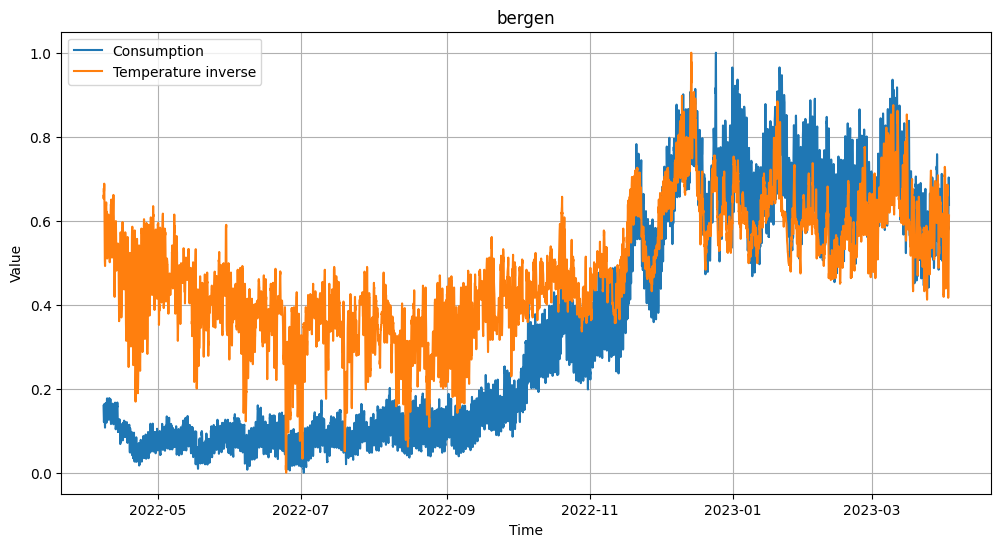

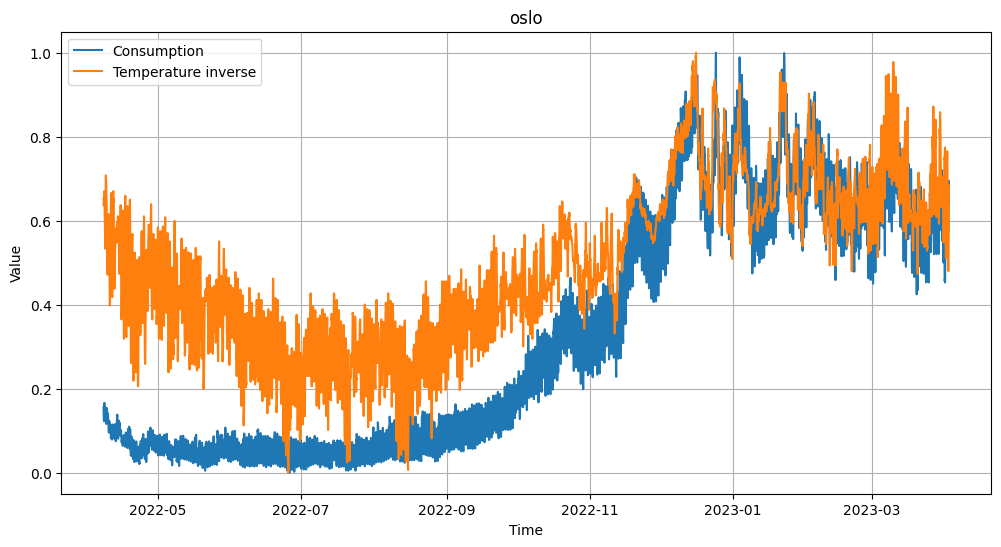

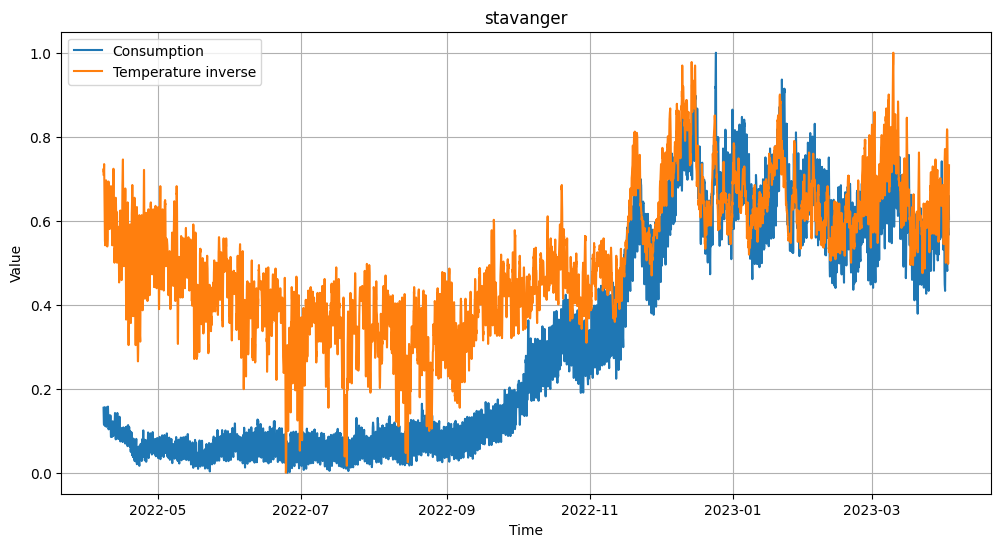

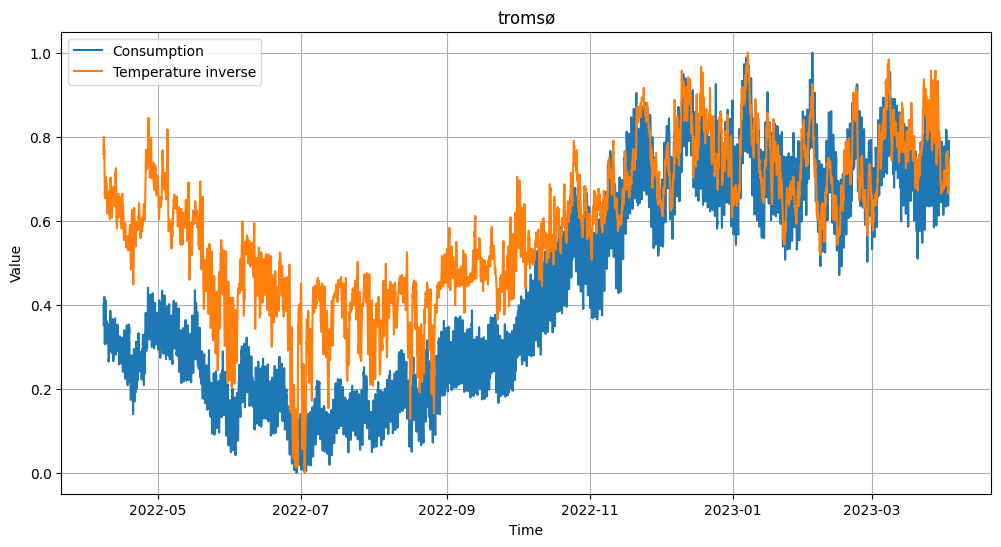

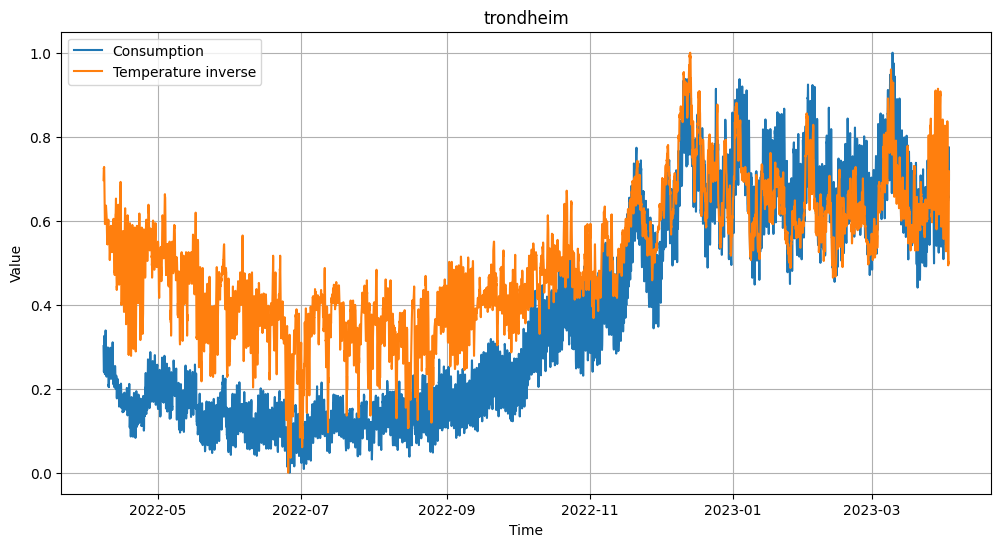

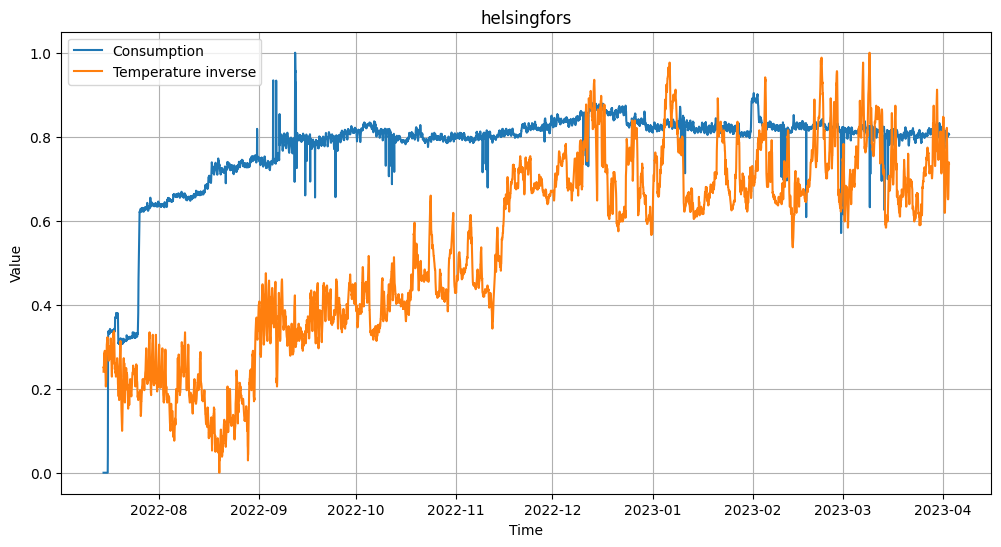

In [3]:
normalize_features = True

# Plot
for city, city_data in data_cities.items():

    # Normalize the "consumption" and "temperature" columns using Min-Max scaling
    min_consumption = city_data['consumption'].min()
    max_consumption = city_data['consumption'].max()
    min_temperature = city_data['temperature'].min()
    max_temperature = city_data['temperature'].max()

    normalized_city_data = city_data.copy()
    if normalize_features:
        normalized_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
        normalized_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))


    # Plot
    plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

    plt.plot(normalized_city_data['time'], normalized_city_data['consumption'], label='Consumption', linestyle='-')
    plt.plot(normalized_city_data['time'], normalized_city_data['temperature'], label='Temperature inverse', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(city)
    plt.legend()
    plt.grid(True)

    plt.show()

In [4]:
# Try calculating correlation for our different features

In [5]:
data[data.location == "oslo"]

time location  consumption  temperature
1     2022-04-07 21:00:00     oslo     4.092830          1.0
6     2022-04-07 22:00:00     oslo     3.818095          0.4
11    2022-04-07 23:00:00     oslo     3.660981          0.3
16    2022-04-08 00:00:00     oslo     3.584066          0.2
21    2022-04-08 01:00:00     oslo     3.549536          0.4
...                   ...      ...          ...          ...
49466 2023-04-02 17:00:00     oslo    12.410225          5.5
49472 2023-04-02 18:00:00     oslo    12.856381          4.8
49478 2023-04-02 19:00:00     oslo    13.010338          0.6
49484 2023-04-02 20:00:00     oslo    12.738356         -0.3
49490 2023-04-02 21:00:00     oslo    12.134655         -1.1

[8641 rows x 4 columns]

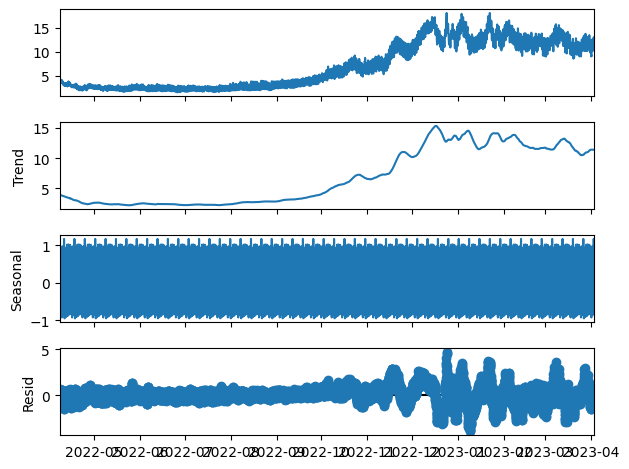

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = data[data.location == "oslo"].set_index('time')[['consumption']]
result = seasonal_decompose(series, period=7*24, model='additive', extrapolate_trend='freq', two_sided=False)
result.plot()
pyplot.show()

In [7]:
df = pd.DataFrame(result.trend + result.resid).reset_index().rename(columns={0: "y"})

In [8]:
df.merge(data[data.location == "oslo"], left_on="time", right_on="time").drop(columns=['location']).corr()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_32981/3999151860.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.merge(data[data.location == "oslo"], left_on="time", right_on="time").drop(columns=['location']).corr()


y  consumption  temperature
y            1.000000     0.990998    -0.883241
consumption  0.990998     1.000000    -0.861854
temperature -0.883241    -0.861854     1.000000

In [9]:
df = data[data.location == "oslo"].reset_index()
model = LinearRegression()

# Fit the model to the training data
model.fit(df.temperature.values.reshape(-1, 1), df.consumption.values.reshape(-1, 1))

# Make predictions on the test data
y_pred = model.predict(df.temperature.values.reshape(-1, 1))
df['yhat'] = y_pred
df['resid'] = df.consumption - df.yhat

<Axes: xlabel='time'>

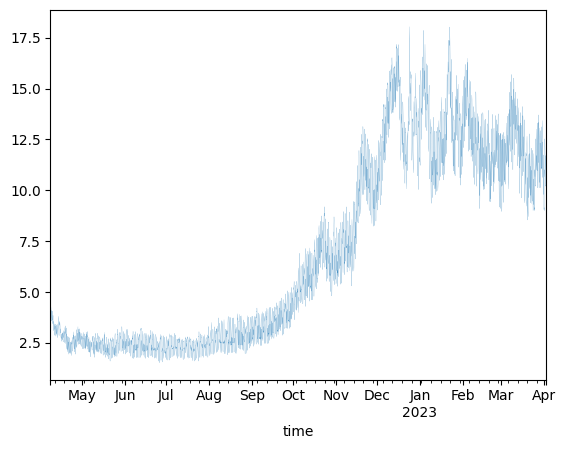

In [10]:
df.set_index("time").consumption.plot(linewidth=0.1)

<Axes: xlabel='time'>

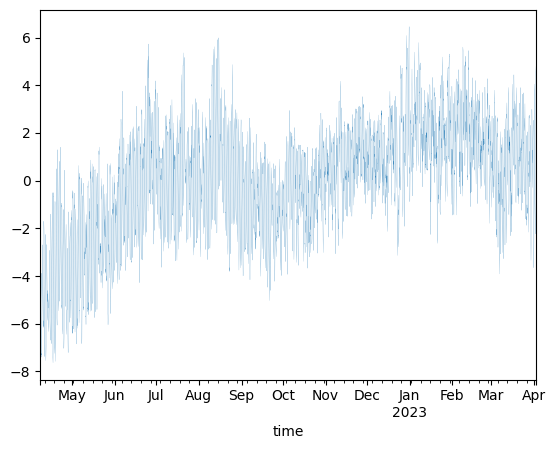

In [11]:
df.set_index("time").resid.plot(linewidth=0.1)

In [12]:
df.corr()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_32981/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


index  consumption   temperature          yhat         resid
index        1.000000     0.881536 -7.140661e-01  7.140661e-01  5.247202e-01
consumption  0.881536     1.000000 -8.618540e-01  8.618540e-01  5.071565e-01
temperature -0.714066    -0.861854  1.000000e+00 -1.000000e+00  2.621077e-14
yhat         0.714066     0.861854 -1.000000e+00  1.000000e+00 -2.796188e-14
resid        0.524720     0.507156  2.621077e-14 -2.796188e-14  1.000000e+00

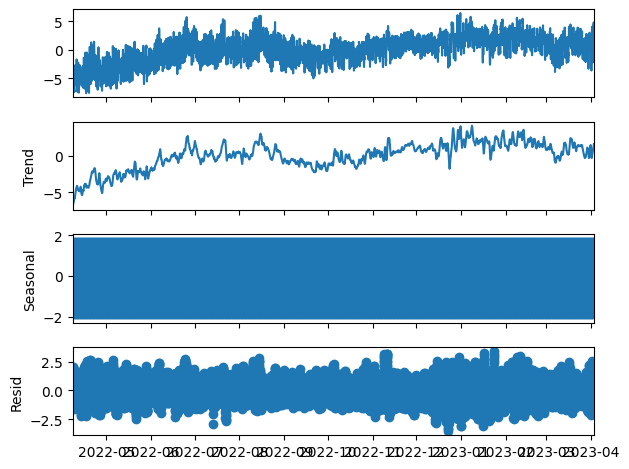

In [13]:
series = df.set_index('time')[['resid']]
result = seasonal_decompose(series, period=24, model='additive', extrapolate_trend='freq', two_sided=False)
result.plot()
pyplot.show()

<Axes: xlabel='time'>

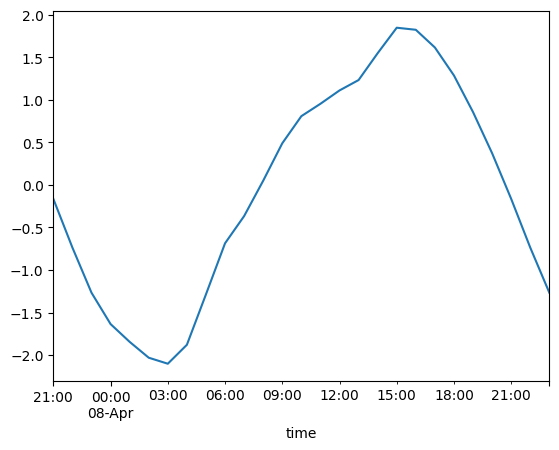

In [14]:
result.seasonal[result.seasonal.index < "2022-04-09"].plot()

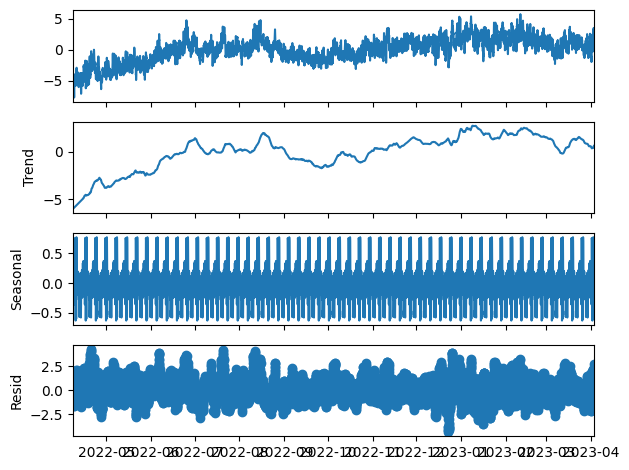

In [15]:
result2 = seasonal_decompose(result.trend + result.resid, period=7*24, model='additive', extrapolate_trend='freq', two_sided=False)
result2.plot()
pyplot.show()

<Axes: xlabel='time'>

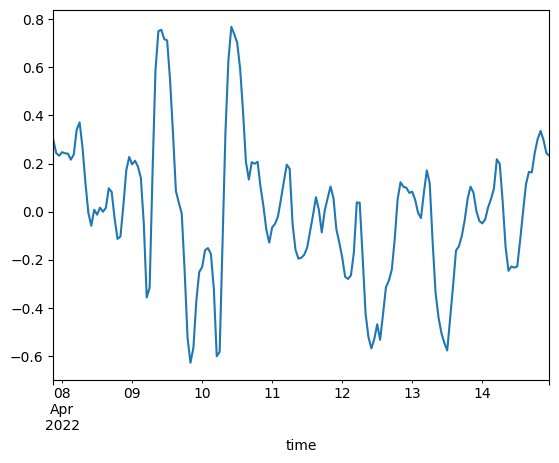

In [16]:
result2.seasonal[result2.seasonal.index < "2022-04-15"].plot()

In [17]:
df['daily_seasonal'] = pd.DataFrame(result.seasonal).reset_index().seasonal
df['weekly_seasonal'] = pd.DataFrame(result2.seasonal).reset_index().seasonal

In [18]:
df

index                time location  consumption  temperature       yhat  \
0         1 2022-04-07 21:00:00     oslo     4.092830          1.0   9.811698   
1         6 2022-04-07 22:00:00     oslo     3.818095          0.4  10.087186   
2        11 2022-04-07 23:00:00     oslo     3.660981          0.3  10.133101   
3        16 2022-04-08 00:00:00     oslo     3.584066          0.2  10.179015   
4        21 2022-04-08 01:00:00     oslo     3.549536          0.4  10.087186   
...     ...                 ...      ...          ...          ...        ...   
8636  49466 2023-04-02 17:00:00     oslo    12.410225          5.5   7.745539   
8637  49472 2023-04-02 18:00:00     oslo    12.856381          4.8   8.066941   
8638  49478 2023-04-02 19:00:00     oslo    13.010338          0.6   9.995357   
8639  49484 2023-04-02 20:00:00     oslo    12.738356         -0.3  10.408588   
8640  49490 2023-04-02 21:00:00     oslo    12.134655         -1.1  10.775906   

         resid  daily_seasonal  weekly_seasonal  
0    -5.718868       -0.164046         0.297641  
1    -6.269091       -0.736876         0.243227  
2    -6.472120       -1.266874         0.232783  
3    -6.594949       -1.635479         0.247328  
4    -6.537650       -1.844674         0.242668  
...        ...             ...              ...  
8636  4.664686        1.615833         0.205663  
8637  4.789440        1.286642         0.199343  
8638  3.014981        0.856355         0.207491  
8639  2.329768        0.372667         0.103984  
8640  1.358749       -0.164046         0.023356  

[8641 rows x 9 columns]

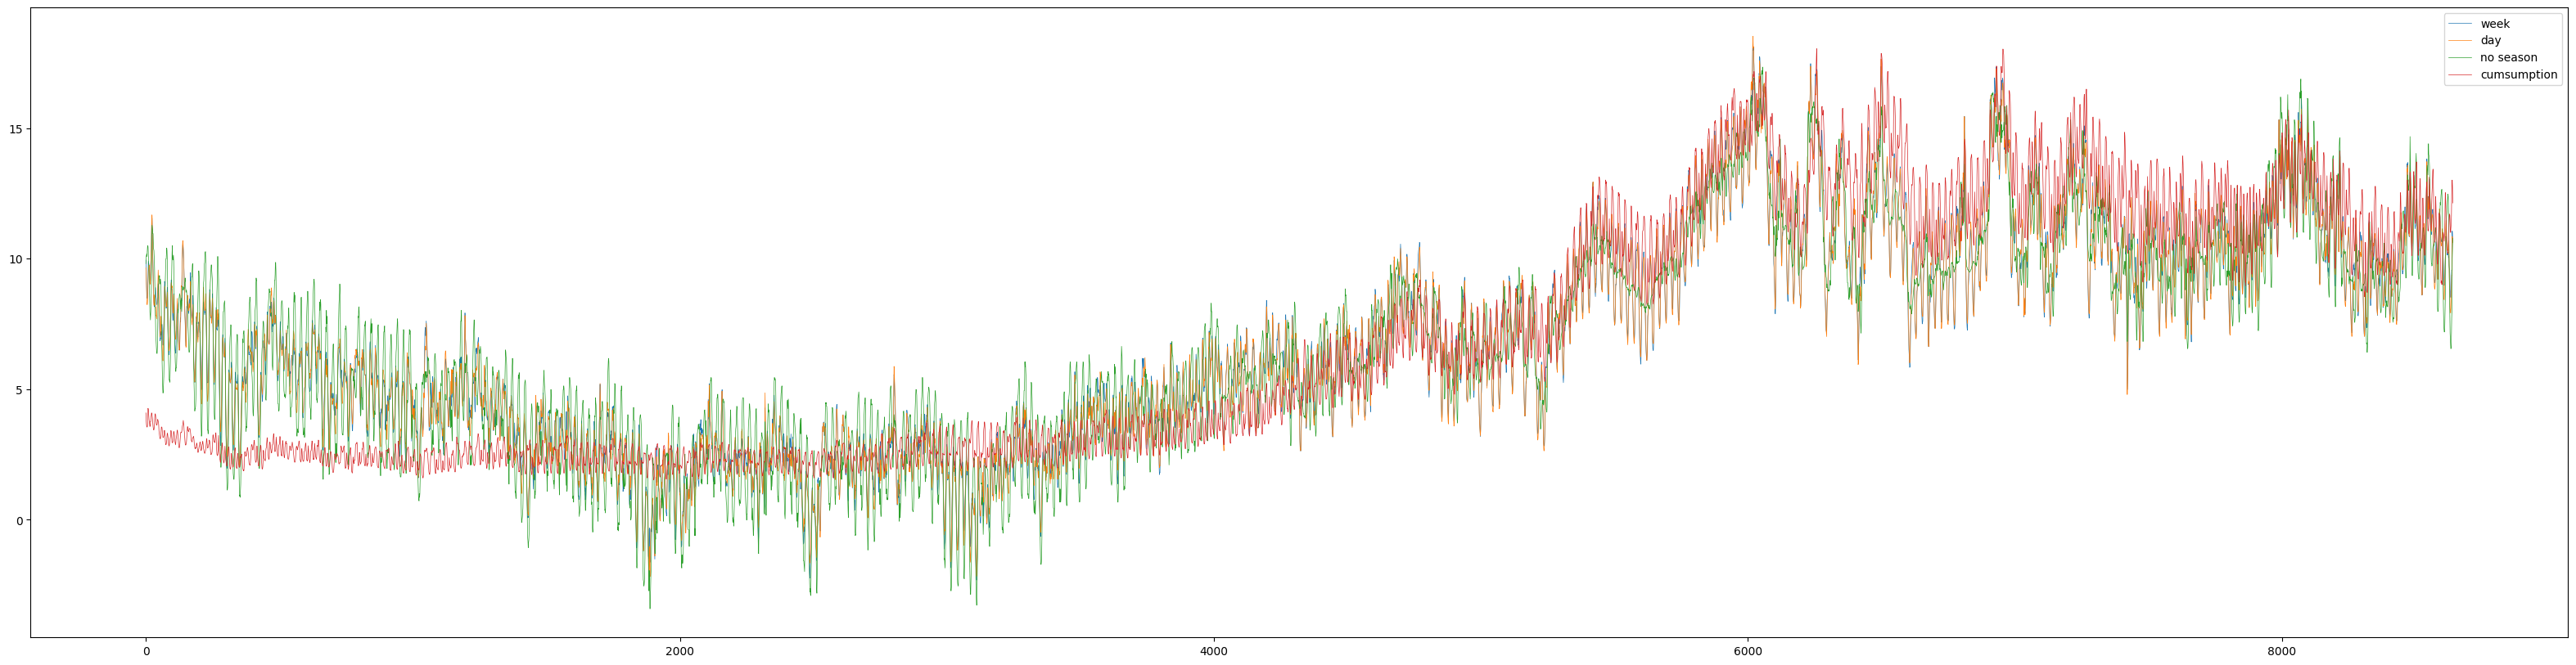

In [19]:
fig, ax = plt.subplots(figsize=(40,10))
ax.plot(df.yhat+df.weekly_seasonal+df.daily_seasonal, label="week", linewidth=0.5)
ax.plot(df.yhat+df.daily_seasonal, label="day", linewidth=0.5)
ax.plot(df.yhat, label="no season", linewidth=0.5)
ax.plot(df.consumption, label="cumsumption", linewidth=0.5)
ax.legend()
plt.show()

In [20]:
df['yhat_w_day'] = df.yhat+df.daily_seasonal

In [21]:
df['yhat_w_day_and_week'] = df.yhat+df.daily_seasonal+df.weekly_seasonal

In [22]:
((df.consumption - df.yhat_w_day)**2).mean()

3.875696859205856

In [23]:
from prophet import Prophet

In [24]:
pr_df = df[['time', 'consumption', 'temperature']].copy()

In [25]:
pr_df.rename(columns={'time':'ds', 'consumption': 'y'}, inplace=True)

In [26]:
m = Prophet()
m.add_regressor('temperature')
m.fit(pr_df)
fcst = m.predict(pr_df)

11:29:54 - cmdstanpy - INFO - Chain [1] start processing
11:29:56 - cmdstanpy - INFO - Chain [1] done processing


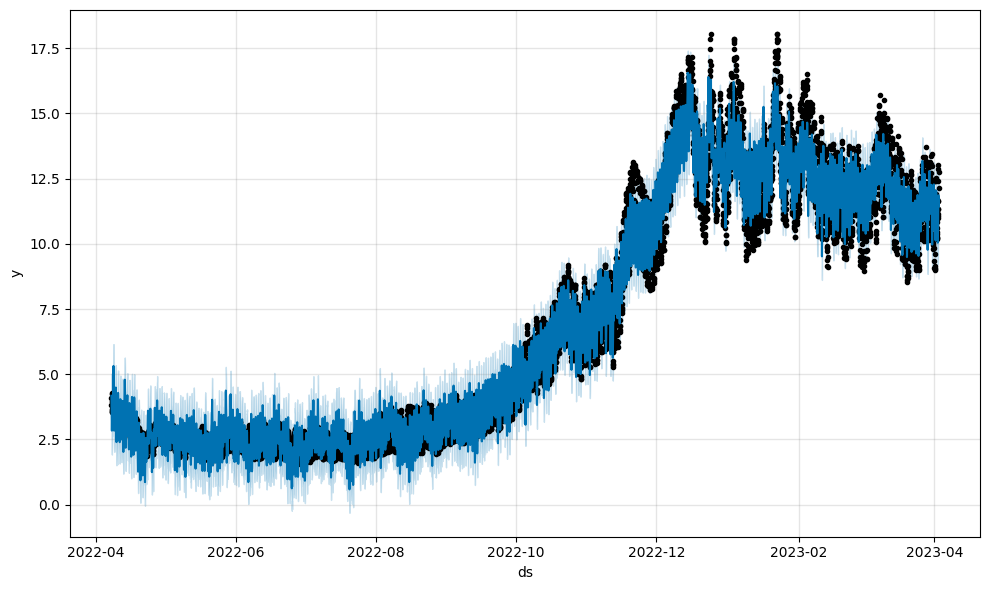

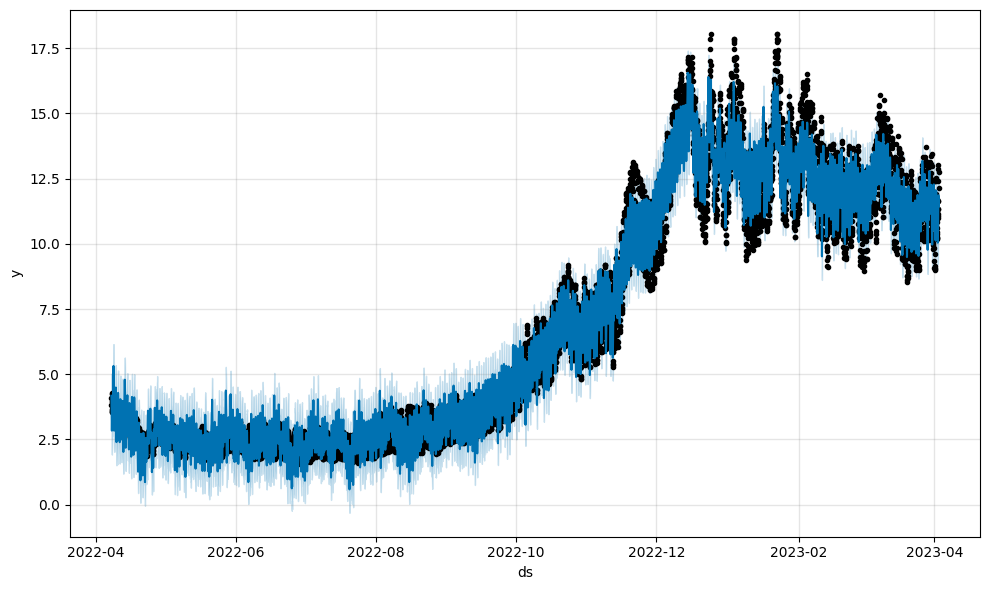

In [27]:
m.plot(fcst)

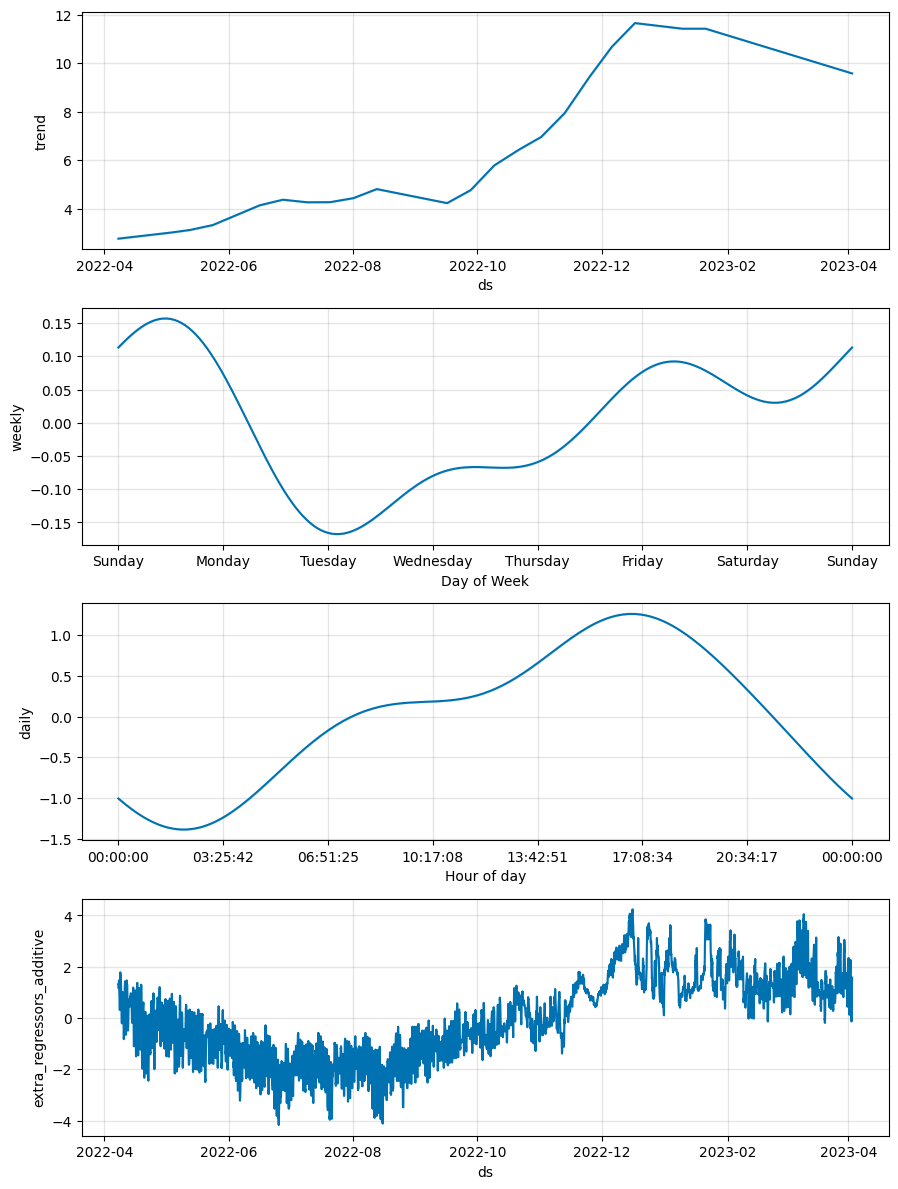

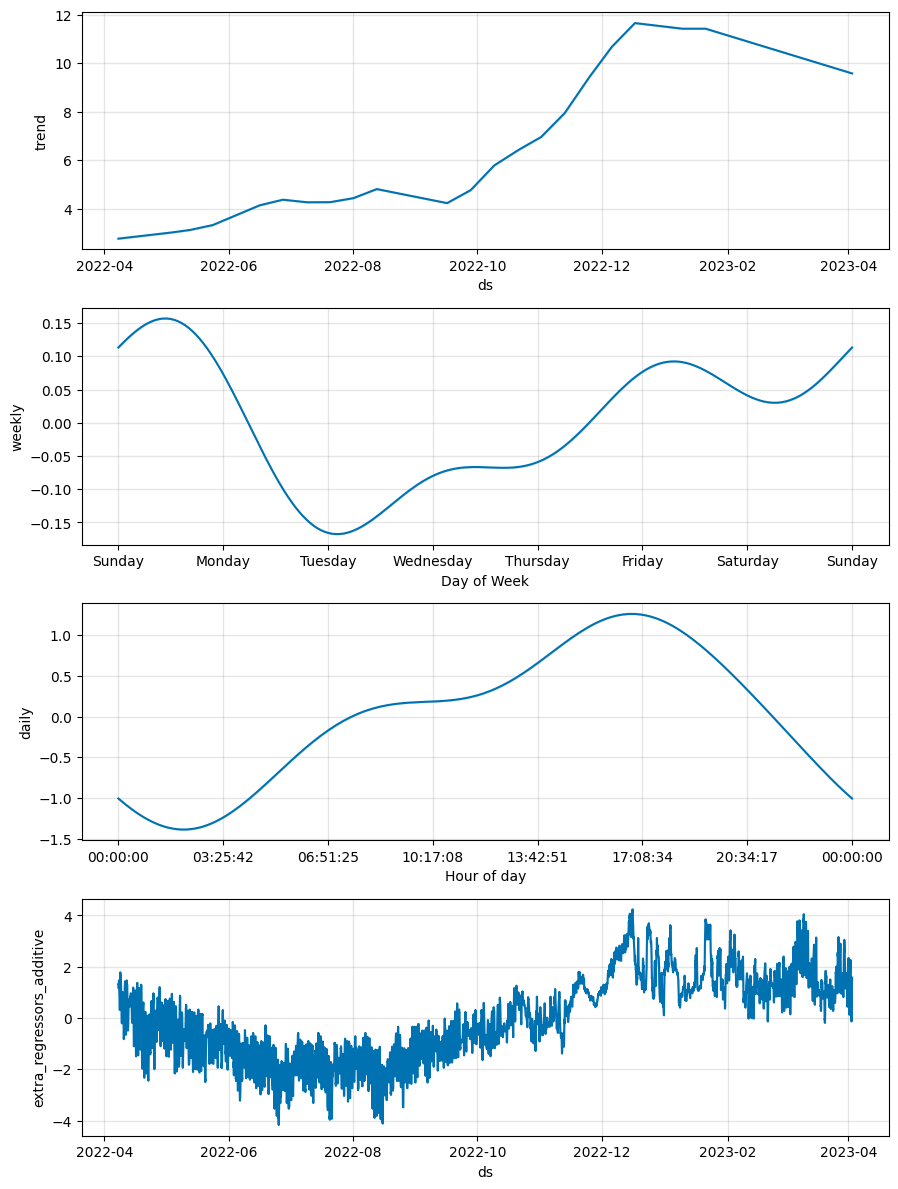

In [28]:
m.plot_components(fcst)

In [29]:
from prophet.utilities import regressor_coefficients

In [30]:
regressor_coefficients(m)

regressor regressor_mode    center  coef_lower    coef  coef_upper
0  temperature       additive  7.392883     -0.1859 -0.1859     -0.1859

In [31]:
from prophet.diagnostics import cross_validation # mkae sure horizon is 36 hours such that it is until midnight and next day
df_cv = cross_validation(m, initial='300 days', period='1 days', horizon = '1 days')

  0%|          | 0/60 [00:00<?, ?it/s]

11:29:58 - cmdstanpy - INFO - Chain [1] start processing
11:29:59 - cmdstanpy - INFO - Chain [1] done processing
11:30:00 - cmdstanpy - INFO - Chain [1] start processing
11:30:01 - cmdstanpy - INFO - Chain [1] done processing
11:30:01 - cmdstanpy - INFO - Chain [1] start processing
11:30:02 - cmdstanpy - INFO - Chain [1] done processing
11:30:02 - cmdstanpy - INFO - Chain [1] start processing
11:30:03 - cmdstanpy - INFO - Chain [1] done processing
11:30:03 - cmdstanpy - INFO - Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing
11:30:05 - cmdstanpy - INFO - Chain [1] start processing
11:30:06 - cmdstanpy - INFO - Chain [1] done processing
11:30:06 - cmdstanpy - INFO - Chain [1] start processing
11:30:08 - cmdstanpy - INFO - Chain [1] done processing
11:30:08 - cmdstanpy - INFO - Chain [1] start processing
11:30:10 - cmdstanpy - INFO - Chain [1] done processing
11:30:10 - cmdstanpy - INFO - Chain [1] start processing
11:30:12 - cmdstanpy - INFO - Chain [1]

In [40]:
df_cv

ds       yhat  yhat_lower  yhat_upper          y  \
0    2023-02-01 22:00:00  14.166753   13.359603   15.018435  14.672303   
1    2023-02-01 23:00:00  13.750716   12.906298   14.561844  13.950541   
2    2023-02-02 00:00:00  13.450216   12.586679   14.231844  13.526602   
3    2023-02-02 01:00:00  13.283544   12.437241   14.129373  13.313333   
4    2023-02-02 02:00:00  13.187922   12.282771   14.070905  13.144260   
...                  ...        ...         ...         ...        ...   
1435 2023-04-02 17:00:00  11.324715   10.475603   12.174096  12.410225   
1436 2023-04-02 18:00:00  11.328938   10.519900   12.194722  12.856381   
1437 2023-04-02 19:00:00  11.848156   11.037355   12.667338  13.010338   
1438 2023-04-02 20:00:00  11.666263   10.811038   12.608182  12.738356   
1439 2023-04-02 21:00:00  11.421845   10.511976   12.260691  12.134655   

                  cutoff  
0    2023-02-01 21:00:00  
1    2023-02-01 21:00:00  
2    2023-02-01 21:00:00  
3    2023-02-01 21:00:00  
4    2023-02-01 21:00:00  
...                  ...  
1435 2023-04-01 21:00:00  
1436 2023-04-01 21:00:00  
1437 2023-04-01 21:00:00  
1438 2023-04-01 21:00:00  
1439 2023-04-01 21:00:00  

[1440 rows x 6 columns]

In [32]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 0 days 03:00:00  0.353985  0.594966  0.477880  0.041706  0.036594  0.041344   
1 0 days 04:00:00  0.342332  0.585091  0.475315  0.043100  0.039348  0.042555   
2 0 days 05:00:00  0.342830  0.585517  0.489480  0.045435  0.043208  0.044786   
3 0 days 06:00:00  0.385503  0.620889  0.531975  0.050242  0.047392  0.049231   
4 0 days 07:00:00  0.524276  0.724069  0.623090  0.058915  0.052010  0.057393   

   coverage  
0  0.827778  
1  0.854167  
2  0.888889  
3  0.855556  
4  0.722222

In [33]:
df_p.describe()

horizon        mse       rmse        mae       mape  \
count                         22  22.000000  22.000000  22.000000  22.000000   
mean             0 days 13:30:00   0.749863   0.843721   0.694201   0.060593   
std    0 days 06:29:36.911686533   0.362959   0.199516   0.164064   0.017818   
min              0 days 03:00:00   0.342332   0.585091   0.475315   0.041706   
25%              0 days 08:15:00   0.522866   0.723094   0.600786   0.046732   
50%              0 days 13:30:00   0.619533   0.786973   0.640146   0.054360   
75%              0 days 18:45:00   0.876260   0.936078   0.773459   0.067119   
max              1 days 00:00:00   1.561113   1.249445   1.025459   0.098413   

           mdape      smape   coverage  
count  22.000000  22.000000  22.000000  
mean    0.052609   0.059010   0.669571  
std     0.014665   0.015703   0.130172  
min     0.036594   0.041344   0.452778  
25%     0.041782   0.047612   0.573611  
50%     0.047670   0.053986   0.695833  
75%     0.060336   0.065619   0.734375  
max     0.082472   0.091612   0.888889

In [34]:
df_cv.corr()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_32981/2864518407.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cv.corr()


yhat  yhat_lower  yhat_upper         y
yhat        1.000000    0.999316    0.999316  0.831589
yhat_lower  0.999316    1.000000    0.998502  0.829864
yhat_upper  0.999316    0.998502    1.000000  0.831947
y           0.831589    0.829864    0.831947  1.000000

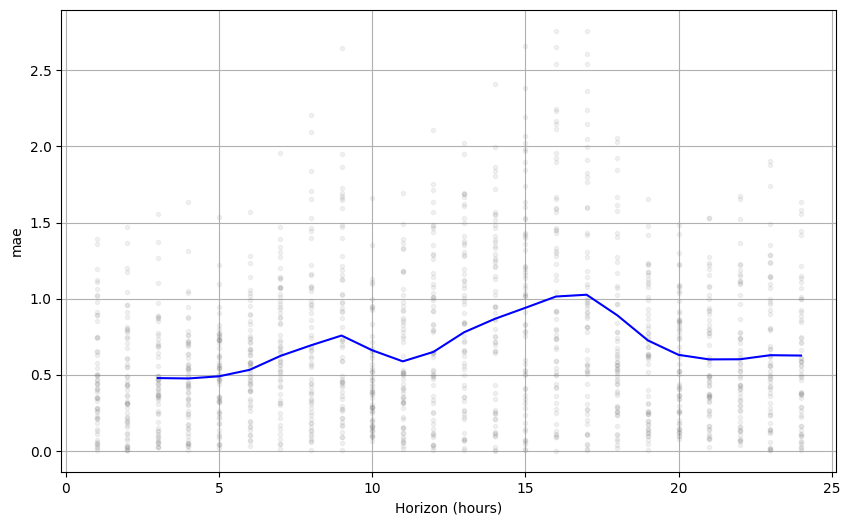

In [35]:


# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')


In [36]:
pr_df.describe()

y  temperature
count  8641.000000  8641.000000
mean      6.876428     7.392883
std       4.672634     8.770901
min       1.520560   -15.400000
25%       2.610569     0.900000
50%       4.871180     7.900000
75%      11.458471    14.200000
max      18.045011    29.799999

In [37]:
pr_df

ds          y  temperature
0    2022-04-07 21:00:00   4.092830          1.0
1    2022-04-07 22:00:00   3.818095          0.4
2    2022-04-07 23:00:00   3.660981          0.3
3    2022-04-08 00:00:00   3.584066          0.2
4    2022-04-08 01:00:00   3.549536          0.4
...                  ...        ...          ...
8636 2023-04-02 17:00:00  12.410225          5.5
8637 2023-04-02 18:00:00  12.856381          4.8
8638 2023-04-02 19:00:00  13.010338          0.6
8639 2023-04-02 20:00:00  12.738356         -0.3
8640 2023-04-02 21:00:00  12.134655         -1.1

[8641 rows x 3 columns]

In [38]:
from statsmodels.graphics.tsaplots import plot_acf

